In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib
#import anvil.server
import math
import warnings
#anvil.server.connect("MULC3WA3OE5ETI6GT6HMSZRI-ZKH2WPDHB453YQOY")
warnings.filterwarnings("ignore") # ignore warning
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns',1000)
pd.set_option("display.max_colwidth", None)

In [2]:
! pip install anvil-uplink
#! pip install anvil
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 2.0 MB/s 
     |████████████████████████████████| 51 kB 120 kB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=0a35cfaff2c3de015d4f41931b6523b88009d2393b62d07c72db9bb9c0b616da
  Stored in directory: /root/.cache/pip/wheels/ea/f9/a1/34e2943cce3cf7daca304bfc35e91280694ced9194a487ce2f
Successfully built ws4py


Saving kaggle.json to kaggle.json
ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           7327        219  1.0              
madhurpant/world-deaths-and-causes-1990-2019                    World Deaths and Causes (1990 - 2019)               442KB  2022-11-29 07:09:27           1402         35  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                     3MB  2022-11-16 13:52:31           4759        106  1.0              
thedevastator/how-much-sle

In [3]:
import anvil.server
anvil.server.connect("MULC3WA3OE5ETI6GT6HMSZRI-ZKH2WPDHB453YQOY")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [4]:
!kaggle datasets list -s"YouTube Trending Video Dataset (updated daily)"
!kaggle datasets download -d "rsrishav/youtube-trending-video-dataset" -p "/content/new_data"

ref                                                          title                                            size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rsrishav/youtube-trending-video-dataset                      YouTube Trending Video Dataset (updated daily)    1GB  2022-12-10 12:33:35          16027        392  1.0              
datasnaek/youtube                                            Trending YouTube Video Statistics and Comments   56MB  2017-10-25 19:26:15          19699        324  0.7647059        
syahrulhamdani/indonesias-trending-youtube-video-statistics  Indonesia's Trending YouTube Video Statistics    74MB  2022-12-10 06:00:58           1535         60  1.0              
jessevent/all-kaggle-datasets                                Complete Kaggle Datasets Collectio

In [5]:
#filepath1="new_data/US_category_id.json"
filepath1 = ""
filepath2 = ""
from zipfile import ZipFile
with ZipFile(r"/content/new_data/youtube-trending-video-dataset.zip") as myzip:
    filepath1 = myzip.open("US_category_id.json")
    filepath2 = myzip.open("US_youtube_trending_data.csv")

category_id_df = pd.read_json(filepath1)
#category_id_df

In [6]:
#filepath2="new_data/US_youtube_trending_data.csv"
videos_df = pd.read_csv(filepath2,header='infer')
#videos_df.head()

In [7]:
def clean_video_csv(video_df,country_code):
    """
    This function is to remove unnecessary chars like '"',',','\r'which will cause errors when copy csv files into staging table.
    
    Parameters:
    video_df: Dataframe from read_csv file
    filepath: videos csv filepath
    
    Return:
    video_df: Dataframe which remove unnecessary chars
    """
    video_df["tags"] = video_df["tags"].apply(lambda x:x.replace('"',""))
    video_df["title"] = video_df["title"].apply(lambda x:x.replace(',',' '))
    video_df["channelTitle"] = video_df["channelTitle"].apply(lambda x:x.replace(',',' '))
    video_df["description"] = video_df["description"].apply(lambda x:str(x).replace('\r',''))
    video_df["description"] = video_df["description"].apply(lambda x:str(x).replace(',',' '))
    video_df["description"] = video_df["description"].apply(lambda x:str(x).replace('"',''))
    video_df["country"] = country_code
    return video_df
#Clean videos csv files for selected country code
country_code='US'
"""
for c in country_code:
    filepath= "new_data/"+c+"_youtube_trending_data.csv"
    video_df = pd.read_csv(filepath,header='infer')
    savepath = "new_data/"+c+"cleaned_data.csv"
    video_df = clean_video_csv(video_df,c)
    video_df.to_csv(savepath,index=False)
"""
#filepath= "new_data/"+c+"_youtube_trending_data.csv"
#$video_df = pd.read_csv(filepath,header='infer')
savepath = "new_data/"+country_code+"cleaned_data.csv"
video_df = clean_video_csv(videos_df,country_code)
video_df.to_csv(savepath,index=False)

In [8]:
def category_extract (df,country_code):
    """
    The function is to extract category id and category title from category_id json files
    
    Parameters:
    df: Dataframe of read_json file
    filepath: category_id json filepath
    
    Return:
    category_df: Dataframe with columns: category_id,category_title,category_filename,country_code
    
    """
    category_id = []
    category_title = []
    for i in range(df.shape[0]):
        category_id.append(df.iloc[i]["items"]['id'])
        category_title.append(df.iloc[i]["items"]["snippet"]["title"])
    category_df = pd.DataFrame()
    category_df["category_id"] = category_id
    category_df["category_title"] = category_title
    category_df.insert(category_df.shape[1],"country_code",country_code)
    return category_df

#Extract category title and id from json file of each country

"""
category_all = pd.DataFrame()
for c in country_code:
    filepath="new_data/"+c+"_category_id.json"
    category_id_df = pd.read_json(filepath)
    category_all = pd.concat([category_all,category_extract(category_id_df,c)])
    
#category_all.tail()
savepath = "new_data/category_all.csv"
category_all.to_csv(savepath,index=False)
"""
category_all = pd.DataFrame()
category_all = pd.concat([category_all,category_extract(category_id_df,country_code)])
savepath = "new_data/category_all.csv"
category_all.to_csv(savepath,index=False)

In [9]:
US = pd.read_csv("new_data/UScleaned_data.csv")
#US.head()

In [10]:
category = pd.read_csv("new_data/category_all.csv")

In [11]:
trendingdate_df = US.groupby("video_id").trending_date.describe().reset_index()
trendingdate_df

,video_id,count,unique,top,freq
0,--14w5SOEUs,10,5,2021-06-11T00:00:00Z,2
1,--2O86Z0hsM,4,4,2022-03-11T00:00:00Z,1
2,--40TEbZ9Is,5,5,2021-09-21T00:00:00Z,1
3,--DKkzWVh-E,4,4,2021-12-08T00:00:00Z,1
4,--FmExEAsM8,4,4,2021-12-02T00:00:00Z,1
...,...,...,...,...,...
31526,zzCrFWjKPy8,5,5,2022-08-30T00:00:00Z,1
31527,zzd4ydafGR0,10,10,2021-02-12T00:00:00Z,1
31528,zziBybeSAtw,2,2,2021-01-17T00:00:00Z,1
31529,zzk09ESX7e0,14,7,2021-06-03T00:00:00Z,2


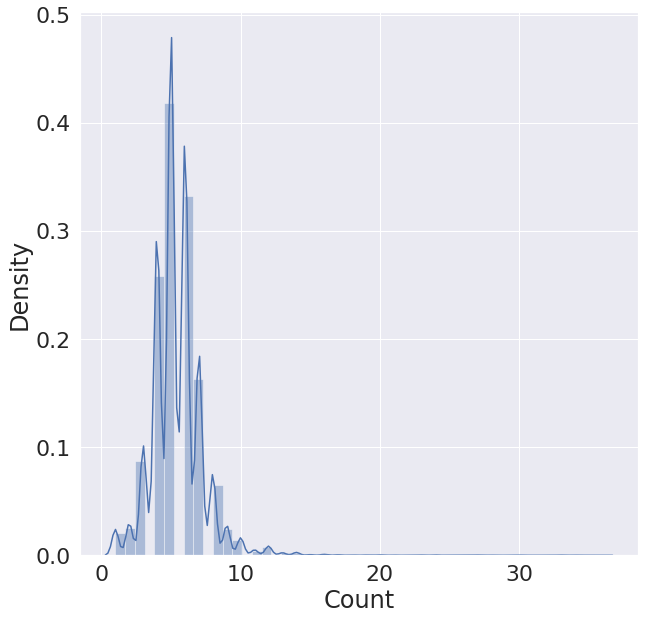

In [12]:
pd.DataFrame(trendingdate_df["count"].astype('int').copy()).describe()
matplotlib.pyplot.figure(figsize=(10,10))
sns.set(font_scale=2)
sns.distplot(trendingdate_df["count"])
matplotlib.pyplot.xlabel('Count');
matplotlib.pyplot.ylabel('Density');

In [13]:
trendingdate_df["count"].mean()

5.422917129174463

In [14]:
videos_df.categoryId.nunique()
#videos_df.head()

15

In [15]:
videos_df[videos_df["view_count"].idxmax():videos_df["view_count"].idxmax()+1]

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,country
152788,gQlMMD8auMs,BLACKPINK - ‘Pink Venom’ M/V,2022-08-19T04:00:13Z,UCOmHUn--16B90oW2L6FRR3A,BLACKPINK,10,2022-09-10T00:00:00Z,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블핑|제니|로제|리사|지수|LISA|JISOO|JENNIE|ROSÉ|BLINK|블링크|BLACKPINK PINK VENOM|PINK VENOM|핑크베놈|블랙핑크 핑크베놈|BLACKPINK 핑크베놈|BORN PINK|BLACKPINK BORN PINK|본핑크|블랙핑크 본핑크,277791741,12993894,0,3534337,https://i.ytimg.com/vi/gQlMMD8auMs/default.jpg,False,False,BLACKPINK - ‘Pink Venom’ M/VKick in the door Waving the coco 팝콘이나 챙겨 껴들 생각 말고I talk that talk Runways I walk walk 눈 감고 pop pop 안 봐도 척 One by one then Two by two내 손끝 툭 하나에 다 무너지는 중가짜 쇼 치곤 화려했지Makes no sense You couldn’t get a dollar outta me자 오늘 밤이야 난 독을 품은 꽃네 혼을 빼앗은 다음 Look what you made us do 천천히 널 잠재울 FIRE 잔인할 만큼 아름다워 I bring the pain like This that pink venomThis that pink venomThis that pink venomGet ‘em get ‘em get ‘emStraight to ya dome like whoa whoa whoa Straight to ya dome like ah ah ah Taste that pink venomTaste that pink venomTaste that pink venomGet ‘em get ‘em get ‘emStraight to ya dome like whoa whoa whoa Straight to ya dome like ah ah ah Black paint and ammo got bodies like RamboRest in peace please light up a candleThis da life of a vandal masked up and I’m still in CelineDesigner crimes or it wouldn’t be meDiamonds shinin’ drive in silence I don’t mind it I’m ridin’ Flyin’ private side by side with da pilot Up in the sky And I’m wildin’ stylin’ on them and there’s no chanceCuz we got bodies on bodies like this a slow dance 자 오늘 밤이야 난 독을 품은 꽃네 혼을 빼앗은 다음 Look what you made us do 천천히 널 잠재울 FIRE 잔인할 만큼 아름다워 I bring the pain likeThis that pink venomThis that pink venomThis that pink venomGet ‘em get ‘em get ‘emStraight to ya dome like whoa whoa whoa Straight to ya dome like ah ah ah Taste that pink venomTaste that pink venomTaste that pink venomGet ‘em get ‘em get ‘emStraight to ya dome like whoa whoa whoa Straight to ya dome like ah ah ah 원한다면 provoke us감당 못해 and you know this이미 퍼져버린 shot that potion 네 눈앞은 핑크빛 oceanCome and give me all the smoke 도 아니면 모 like I’m so rock and roll Come and give me all the smoke 다 줄 세워 봐 자 STOP DROPI bring the pain likeLa tatata La tatata La tatata La tatata La tatata La tatata Straight to yaStraight to yaStraight to ya dome likeLa tatata La tatata La tatata La tatataLa tatata La tatataI bring the pain like 00:00 Pink Venom01:56 Join the #PinkVenomChallenge 02:11 Only on YouTube Shorts More about BLACKPINK @http://www.blackpinkofficial.com/http://www.facebook.com/BLACKPINKOFFICIALhttp://www.youtube.com/BLACKPINKOFFICIALhttps://www.instagram.com/BLACKPINKOFFICIALhttps://twitter.com/BLACKPINK#BLACKPINK #블랙핑크 #PreReleaseSingle #PinkVenom #MV #20220819_12amEST #20220819_1pmKST #OutNow #YG,US


In [16]:
corrolation_list = ['view_count', 'likes', 'dislikes', 'comment_count']
hm_data = videos_df[corrolation_list].corr() 
display(hm_data)

,view_count,likes,dislikes,comment_count
view_count,1.000000,0.857948,0.545761,0.603265
likes,0.857948,1.000000,0.524895,0.742890
dislikes,0.545761,0.524895,1.000000,0.439101
comment_count,0.603265,0.742890,0.439101,1.000000


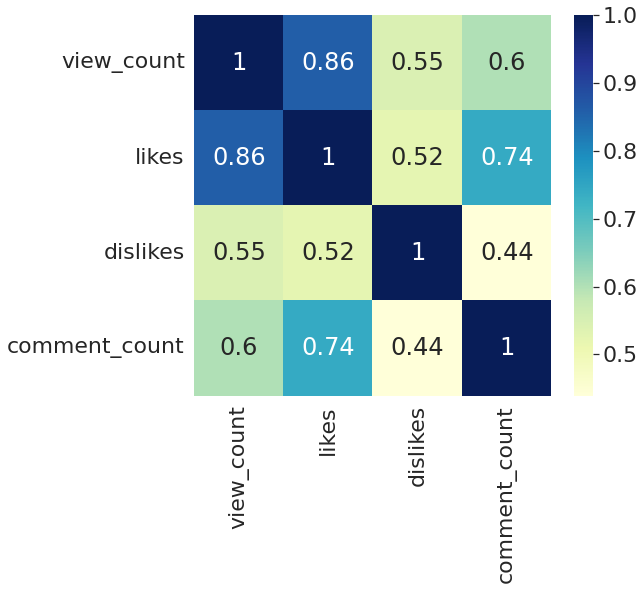

In [17]:
matplotlib.pyplot.figure(figsize=(8,7))
sns.set(font_scale=2)
sns.heatmap(hm_data,cmap="YlGnBu", annot=True);

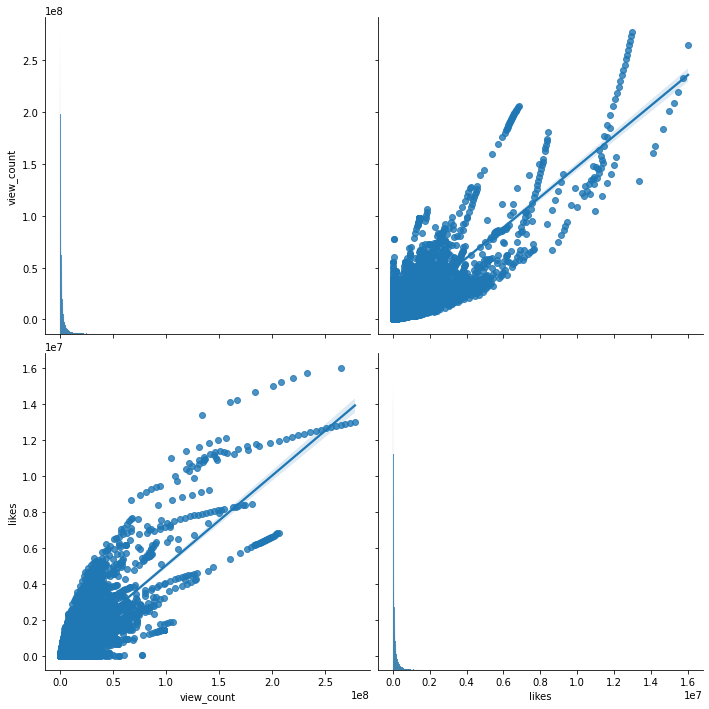

In [ ]:
sns.pairplot(videos_df[['view_count', 'likes']], kind='reg',height=5);

Text(0.5, 1.0, 'Correlation of Likes count and View count')

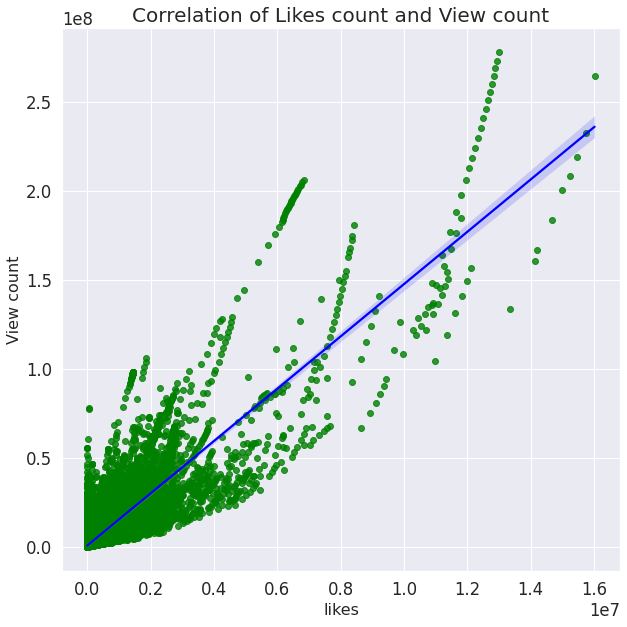

In [18]:
matplotlib.pyplot.figure(figsize=(10,10))
sns.set(font_scale=1.5)
sns.regplot(x=videos_df['likes'], y=videos_df['view_count'],scatter_kws={"color": "green"}, line_kws={"color": "blue"})
matplotlib.pyplot.xlabel('likes', fontsize=16);
matplotlib.pyplot.ylabel('View count', fontsize=16);
matplotlib.pyplot.title('Correlation of Likes count and View count', fontsize=20)

Text(0.5, 1.0, 'Correlation of Dislikes count and View count')

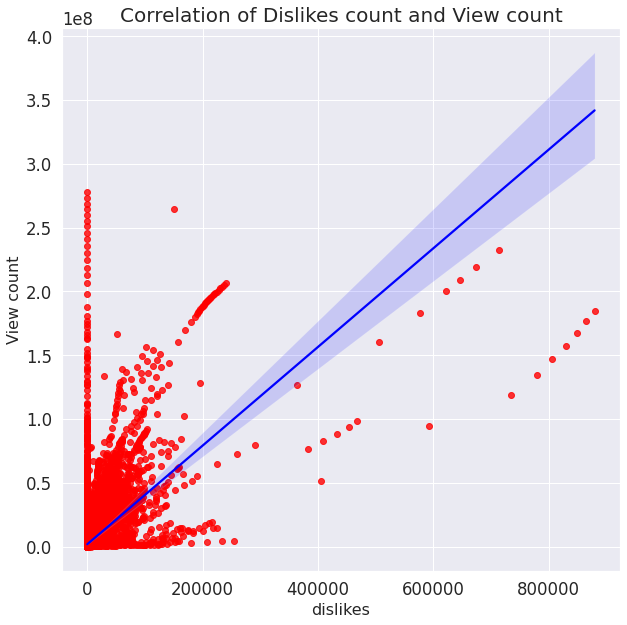

In [19]:
matplotlib.pyplot.figure(figsize=(10,10))
sns.set(font_scale=1.5)
sns.regplot(x=videos_df['dislikes'], y=videos_df['view_count'],scatter_kws={"color": "red"}, line_kws={"color": "blue"}).set(title='correlation of dislikes count and views')
matplotlib.pyplot.xlabel('dislikes', fontsize=16);
matplotlib.pyplot.ylabel('View count', fontsize=16);
matplotlib.pyplot.title('Correlation of Dislikes count and View count', fontsize=20)

Text(0.5, 1.0, 'Correlation of Comment count and View count')

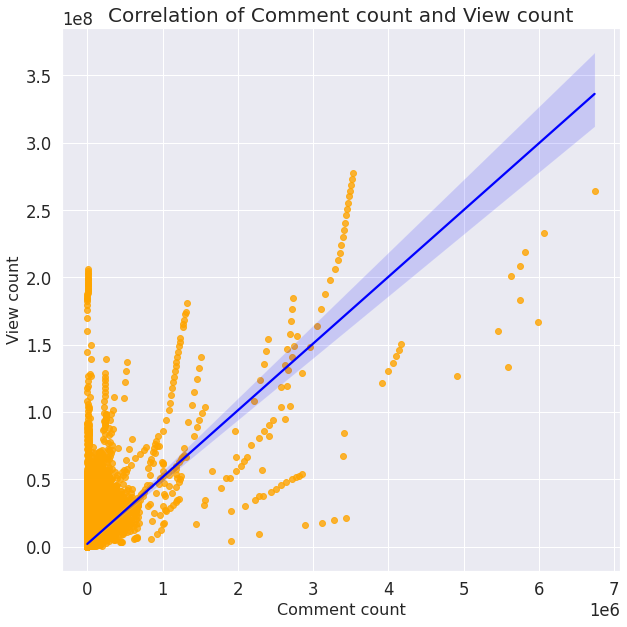

In [20]:
matplotlib.pyplot.figure(figsize=(10,10))
sns.set(font_scale=1.5)
sns.regplot(x=videos_df['comment_count'], y=videos_df['view_count'],scatter_kws={"color": "orange"}, line_kws={"color": "blue"})
matplotlib.pyplot.xlabel('Comment count', fontsize=16);
matplotlib.pyplot.ylabel('View count', fontsize=16);
matplotlib.pyplot.title('Correlation of Comment count and View count', fontsize=20)

In [22]:
US1 =US.merge(category,how="inner",left_on=["categoryId","country"],right_on=["category_id","country_code"])
#US1.info()
US1

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,country,category_id,category_title,country_code
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11T19:20:14Z,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12T00:00:00Z,brawadis|prank|basketball|skits|ghost|funny videos|vlog|vlogging|NBA|browadis|challenges|bmw i8|faze rug|faze rug brother|mama rug and papa rug,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/SubscribeToBrawadisFOLLOW ME ON SOCIAL▶ Twitter: https://twitter.com/Brawadis▶ Instagram: https://www.instagram.com/brawadis/▶ Snapchat: brawadisHi! I’m Brandon Awadis and I like to make dope vlogs pranks reactions challenges and basketball videos. Don’t forget to subscribe and come be a part of the BrawadSquad!,US,22,People & Blogs,US
1,49Z6Mv4_WCA,i don't know what im doing anymore,2020-08-11T20:24:34Z,UCtinbF-Q-fVthA0qrFQTgXQ,CaseyNeistat,22,2020-08-12T00:00:00Z,[None],940036,87111,1860,7052,https://i.ytimg.com/vi/49Z6Mv4_WCA/default.jpg,False,False,ssend love to my sponsor; for a super Limited Time! Go to https://NordVPN.com/casey or use code CASEY to get 70% off a 3 year plan plus 1 additional month free. NORD also brings you security tools like NordPass password manager. which is great. if this is something you need you should do get it. thanks for being. agood sponsor NOrd!! https://NordPass.comMusic Taylor Galford; https://taylorgalford.bandcamp.com/and GurtyBeats.com https://soundcloud.com/gurtybeats,US,22,People & Blogs,US
2,nt3VVyv5pxQ,Try Not To Laugh Challenge #51,2020-08-11T17:00:31Z,UCYJPby9DRCteedh5tfxVbrw,Smosh Pit,22,2020-08-12T00:00:00Z,smosh|smosh pit|smosh games|funny|comedy,591837,44168,409,2652,https://i.ytimg.com/vi/nt3VVyv5pxQ/default.jpg,False,False,You know what time it is— time to try not to laugh!This video was shot with a very limited crew. All cast & crew followed all CDC and California COVID-19 precautions and filming guidelines.Punch that bell icon so you'll know when we add a new episode!SHOP THE SMOSH CLOTHING LINE: https://smosh.storeWatch Every Drive Thru Ever: https://youtu.be/vml4hskxqtEWatch Mystery Piñata Party Challenge: https://youtu.be/WseASWaLVkcWatch Olivia & Noah Haven’t Left Smosh - SmoshCast #74: https://youtu.be/4elY5bL1BvkSubscribe To Smosh Pit: https://smo.sh/Sub2SmoshPitFollow Us:Instagram: https://instagram.com/smoshTikTok: https://smo.sh/TikTokFacebook: https://facebook.com/smoshTwitter: https://twitter.com/smoshIan Hecox: https://www.instagram.com/ianhecox/Courtney Miller: https://www.instagram.com/co_mill/Shayne Topp: https://www.instagram.com/shaynetopp/Damien Haas: https://www.instagram.com/damienhaas/Tommy Bowe: https://www.instagram.com/tomeybones/Check Out Our Other Smosh Channels:Smosh: https://smo.sh/Sub2SmoshSmosh Games: https://smo.sh/Sub2SmoshGamesSmoshCast: https://smo.sh/Sub2SmoshCast,US,22,People & Blogs,US
3,BNeDH6UTmXw,Ten Minutes with Tyler Cameron | Q&A,2020-08-11T22:00:05Z,UCMw7m-ScQ6jV1FQzQnn1y8Q,Tyler Cameron,22,2020-08-12T00:00:00Z,the bachelor|the bachelorette|Tyler c|Tyler Cameron|Tyler c bachelorette|Tyler c bachelor|Tyler Cameron bachelorette|Tyler Cameron bachelor|Hannah brown|Hannah brown bachelorette|Tyler c and Hannah|Tyler c and Hannah b|Tyler c and Hannah bachelorette|Tyler Cameron and Hannah brown|Tyler Cameron and Hannah brown bachelorette|pop culture|Gigi Hadid|Tyler c and Gigi Hadid,105955,4511,69,673,https://i.ytimg.com/vi/BNeDH6UTmXw/default.jpg,False,False,Come hang out me with me for 10 minutes where Brown Bear tries to ask some tough questions and I give him some questionable answers. Y’all are about to get to know the real me!► FOLLOW MEInstagram: www.instagram.com/tylerjcameron3 Twitter: www.instagram.com/tylerjcameron3 Facebook: www.facebook.com/tylerjcameron3FILMED & EDITED BY:Jacob Laham (Brown Bear Visuals)www.i

Text(0.5, 1.0, 'Rank of Number of Video of Top 10 Channel')

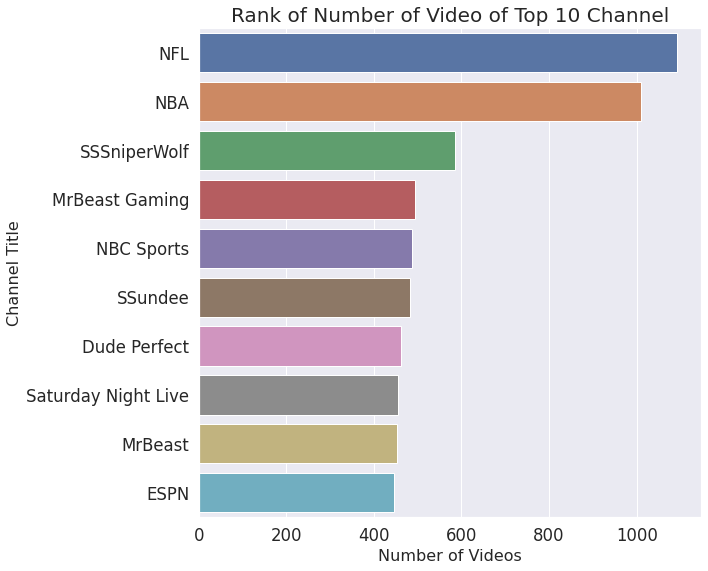

In [24]:
l=US1.channelTitle.value_counts()[:10].index
video_count = pd.DataFrame({'channel_title':l,'no_of_videos':US1.channelTitle.value_counts()[:10]})
video_count.index=[i for i in range(1,11)]
matplotlib.pyplot.figure(figsize=(9,9))
sns.set(font_scale=1.5)
sns.barplot(y="channel_title",x="no_of_videos",data = video_count)
matplotlib.pyplot.xlabel('Number of Videos', fontsize=16);
matplotlib.pyplot.ylabel('Channel Title', fontsize=16);
matplotlib.pyplot.title('Rank of Number of Video of Top 10 Channel', fontsize=20)

In [25]:
print(len(US1.category_title.value_counts()))

15


Text(0.5, 1.0, 'Rank of Number of Video of Category')

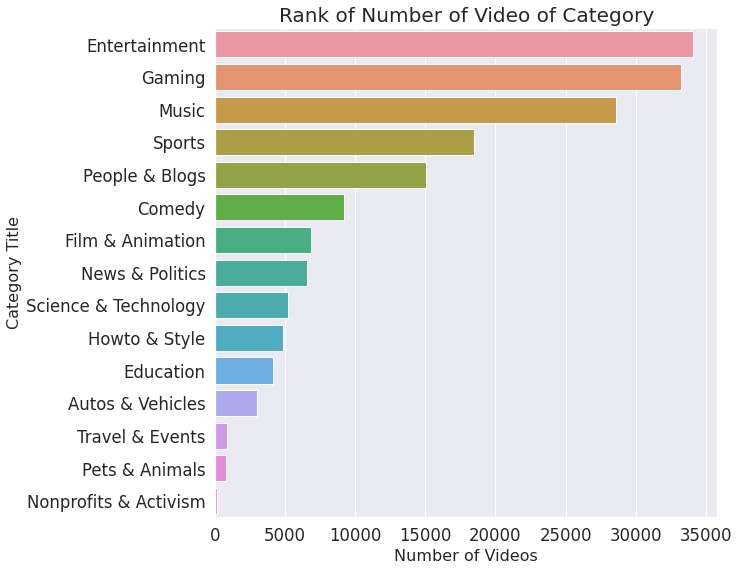

In [26]:
l=US1.category_title.value_counts()[:15].index
video_count = pd.DataFrame({'category_title':l,'no_of_videos':US1.category_title.value_counts()[:15]})
video_count.index=[i for i in range(1,16)]
matplotlib.pyplot.figure(figsize=(9,9))
sns.set(font_scale=1.5)
sns.barplot(x="no_of_videos",y="category_title",data = video_count)
matplotlib.pyplot.xlabel('Number of Videos', fontsize=16);
matplotlib.pyplot.ylabel('Category Title', fontsize=16);
matplotlib.pyplot.title('Rank of Number of Video of Category', fontsize=20)

In [27]:
US1['Views in million'] = US1['view_count'] / 1000000
l=US1[['category_title','Views in million']].groupby('category_title')\
.agg(['mean','count'])\
.sort_values(by=('Views in million','count'), ascending=False)[:15].index
f=pd.DataFrame(US1[['category_title','Views in million']].groupby('category_title')\
.agg(['mean','count'])\
.sort_values(by=('Views in million','count'), ascending=False)[:15])
f["category_title"]=l
f.index=[i for i in range(1,16)]
f.columns
f=f[[('category_title',      ''),(    'Views in million',  'mean'),(    'Views in million', 'count')]]
cm = sns.light_palette("#a275ac", as_cmap=True)

f.style.background_gradient(cmap=cm).set_precision(2).highlight_null('red')


In [28]:
US1["trending_year"]=pd.DatetimeIndex(US1['trending_date']).year
US1["trendingDate"]=pd.DatetimeIndex(US1['trending_date']).date

In [30]:
#print(US1["trendingDate"][:5])
US1["trendingDate"]=pd.to_datetime(US1["trendingDate"],format = "%Y.%m.%d")
US1["publish_date"]=pd.to_datetime(US1["publishedAt"]).dt.date


US1["published_hours"]=pd.to_datetime(US1["publishedAt"]).dt.hour
#print(US1["published_hours"][:5])
US1["publish_date"]=pd.to_datetime(US1["publish_date"],format = "%Y/%m/%d")
l=[]
for i in US1["publish_date"]:
    l.append(i.day_name())
US1["publish_day"]= l

Text(0.5, 1.0, 'Total daily video releases (Since Aug. 2020 to present)')

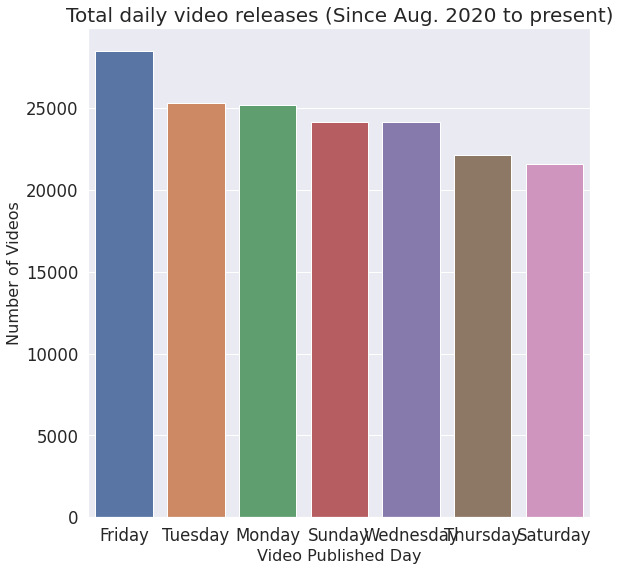

In [32]:
x=US1["publish_day"].value_counts()
#print(x.index)
published_day=pd.DataFrame({"publish_day":x.index,"no_of_videos":x})
published_day.index=[i for i in range(0,7)]
matplotlib.pyplot.figure(figsize=(9,9))
sns.barplot(x="publish_day",y="no_of_videos",data=published_day)
matplotlib.pyplot.xlabel('Video Published Day', fontsize=16);
matplotlib.pyplot.ylabel('Number of Videos', fontsize=16);
matplotlib.pyplot.title('Total daily video releases (Since Aug. 2020 to present)', fontsize=20)

Text(0.5, 1.0, 'Total Hourly video releases (Since Aug. 2020 to present)')

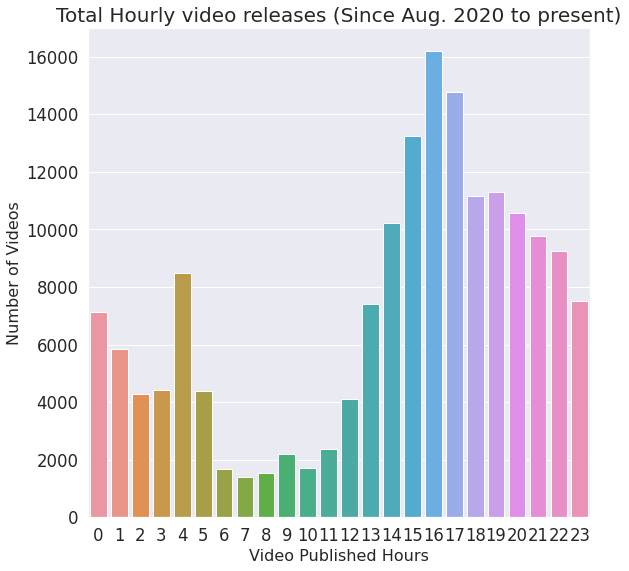

In [33]:
c=US1["published_hours"].value_counts()
hours=pd.DataFrame({"published_hours":c.index,"numb_of_videos":c})
hours.index=[i for i in range(0,24)]
hours=hours.sort_values("published_hours")
matplotlib.pyplot.figure(figsize=(9,9))
sns.barplot(x="published_hours",y="numb_of_videos",data=hours)
matplotlib.pyplot.xlabel('Video Published Hours', fontsize=16);
matplotlib.pyplot.ylabel('Number of Videos', fontsize=16);
matplotlib.pyplot.title('Total Hourly video releases (Since Aug. 2020 to present)', fontsize=20)

In [23]:
US1["trending_date1"] = US1["trending_date"].apply(lambda x: pd.Timestamp(int(x[0:4]),int(x[5:7]),int(x[8:10]),0))

In [ ]:
columns = ["video_id","trending_date1","channelTitle","publishedAt","view_count","likes","dislikes","comment_count","category_title"]
US1 = US1[columns].copy()

In [ ]:
videos = trendingdate_df[trendingdate_df["count"].values>=6].video_id
US2 = US1[ US1.video_id.isin(videos.values)]
US2

,video_id,trending_date1,channelTitle,publishedAt,view_count,likes,dislikes,comment_count,category_title
0,3C66w5Z0ixs,2020-08-12,Brawadis,2020-08-11T19:20:14Z,1514614,156908,5855,35313,People & Blogs
1,49Z6Mv4_WCA,2020-08-12,CaseyNeistat,2020-08-11T20:24:34Z,940036,87111,1860,7052,People & Blogs
2,nt3VVyv5pxQ,2020-08-12,Smosh Pit,2020-08-11T17:00:31Z,591837,44168,409,2652,People & Blogs
4,gPdUslndvVI,2020-08-12,Cole The Cornstar,2020-08-11T23:00:06Z,277338,37533,197,3666,People & Blogs
22,3C66w5Z0ixs,2020-08-13,Brawadis,2020-08-11T19:20:14Z,3017834,183592,9506,41374,People & Blogs
...,...,...,...,...,...,...,...,...,...
170985,F-kvFACZ5yE,2022-04-26,T.D. Jakes,2022-04-03T14:58:54Z,5993854,70282,0,19460,Nonprofits & Activism
170986,F-kvFACZ5yE,2022-04-27,T.D. Jakes,2022-04-03T14:58:54Z,6003393,70402,0,19470,Nonprofits & Activism
170987,F-kvFACZ5yE,2022-04-29,T.D. Jakes,2022-04-03T14:58:54Z,6017799,70619,0,19474,Nonprofits & Activism
170988,F-kvFACZ5yE,2022-04-30,T.D. Jakes,2022-04-03T14:58:54Z,6023847,70704,0,19467,Nonprofits & Activism


In [ ]:
def standardize(data):
    scaler = StandardScaler()
    scaler = scaler.fit(data)
    transformed = scaler.transform(data)
    return scaler,transformed
scaler_views, US_views = standardize(US2.view_count.values.reshape(-1,1))

In [ ]:
mean_view = scaler_views.mean_
mean_view = mean_view[0]
var_view = scaler_views.var_
sqr_view = math.sqrt(var_view)
print(mean_view)
print(sqr_view)

3511132.035195637
9065687.679726692


In [ ]:
US3 = pd.DataFrame()
US3["trending_date1"] = US2["trending_date1"]
US3["video_id"] = US2["video_id"]
US3["views"] = US_views
#US3["likes"] = US_likes
#US3["dislikes"] = US_dislikes
#US3["comment_count"] = US_comments
US3.reset_index(inplace=True)
US3.head()

,index,trending_date1,video_id,views
0,0,2020-08-12,3C66w5Z0ixs,-0.220228
1,1,2020-08-12,49Z6Mv4_WCA,-0.283607
2,2,2020-08-12,nt3VVyv5pxQ,-0.322016
3,4,2020-08-12,gPdUslndvVI,-0.356707
4,22,2020-08-13,3C66w5Z0ixs,-0.054414


In [ ]:
US3.drop("index",axis=1,inplace=True)
US3.head()

,trending_date1,video_id,views
0,2020-08-12,3C66w5Z0ixs,-0.220228
1,2020-08-12,49Z6Mv4_WCA,-0.283607
2,2020-08-12,nt3VVyv5pxQ,-0.322016
3,2020-08-12,gPdUslndvVI,-0.356707
4,2020-08-13,3C66w5Z0ixs,-0.054414


In [ ]:
x=[]
y=[]
#category = []
for v in videos:
    row=[]
    temp_df = US3[US3["video_id"]==v].sort_values(by="trending_date1")
    print (temp_df)
    seq = temp_df.views[0:5].index #first 5 views as input
    #print(seq)    
    for s in seq:
        #print (US3.iloc[s].values[2:])
        row.append(US3.iloc[s].values[2:])
    #print(row)
    x.append(row)
    nextstep = temp_df.views[5:6].values # the last views as output
    y.append(nextstep)

Streaming output truncated to the last 5000 lines.
60885     2022-09-29  x3bqbzSmuSc -0.298668
60900     2022-09-30  x3bqbzSmuSc -0.288849
      trending_date1     video_id     views
87262     2021-05-03  x3uXJ1tLCYM -0.232376
87275     2021-05-04  x3uXJ1tLCYM -0.178818
87288     2021-05-05  x3uXJ1tLCYM -0.163880
87302     2021-05-06  x3uXJ1tLCYM -0.159316
87314     2021-05-07  x3uXJ1tLCYM -0.157464
87326     2021-05-08  x3uXJ1tLCYM -0.155915
87340     2021-05-09  x3uXJ1tLCYM -0.155281
      trending_date1     video_id     views
87042     2021-04-18  x4HIbXjJBNI -0.352174
87061     2021-04-19  x4HIbXjJBNI -0.291853
87082     2021-04-20  x4HIbXjJBNI -0.276181
87103     2021-04-21  x4HIbXjJBNI -0.270175
87123     2021-04-22  x4HIbXjJBNI -0.266958
87145     2021-04-23  x4HIbXjJBNI -0.263563
87168     2021-04-24  x4HIbXjJBNI -0.261165
87189     2021-04-25  x4HIbXjJBNI -0.259484
      trending_date1     video_id     views
80539     2020-09-08  x4c9mZOQY1I -0.370278
80550     2020-09-09  x4c

In [ ]:
#x = np.reshape(x,(len(x),9,1)) #input shape(len(x),timesteps,dimensions)
x = np.reshape(x,(len(x),5,1)) # new
print (x.shape)
y = np.reshape(y,(-1,1))
print (y.shape)
x = x.astype('float64')
y = y.astype('float64')

(13638, 5, 1)
(13638, 1)


In [ ]:
from sklearn.model_selection import ShuffleSplit,train_test_split
x_train,x_testall,y_train,y_testall = train_test_split(x,y,test_size=0.4,random_state=42)
x_val,x_test,y_val,y_test = train_test_split(x_testall,y_testall,test_size=0.5,random_state=42)

In [ ]:
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.layers.core import Dense, Activation, Dropout
import keras
model = Sequential()
model.add(LSTM(64, return_sequences=True,input_shape=(5, 1),activation='tanh'))#32 is output,  input shape是3维: (Batch_size, Time_step, Input_Sizes),
model.add(Dropout(0.2))
model.add(LSTM(128,return_sequences=False,activation='tanh'))
model.add(Dense(1, activation='linear'))#1 is output
#optimizer = RMSprop(lr=0.005)
optimizer = RMSprop(learning_rate=0.005)
model.compile(loss='mean_squared_error', optimizer=optimizer)
from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='view_count5_predict_view_count_future.hdf5', 
                               verbose=1, save_best_only=True)

train_model = model.fit(x_train, y_train, 
          validation_data=(x_val, y_val),
          epochs=50, batch_size=64, callbacks=[checkpointer], verbose=1)
model.load_weights('view_count5_predict_view_count_future.hdf5')


Epoch 1/50
128/128 [==============================] - ETA: 0s - loss: 0.1288
Epoch 1: val_loss improved from inf to 0.01271, saving model to view_count5_predict_view_count_future.hdf5
128/128 [==============================] - 8s 27ms/step - loss: 0.1288 - val_loss: 0.0127
Epoch 2/50
125/128 [============================>.] - ETA: 0s - loss: 0.0554
Epoch 2: val_loss improved from 0.01271 to 0.00586, saving model to view_count5_predict_view_count_future.hdf5
128/128 [==============================] - 2s 18ms/step - loss: 0.0542 - val_loss: 0.0059
Epoch 3/50
125/128 [============================>.] - ETA: 0s - loss: 0.0346
Epoch 3: val_loss did not improve from 0.00586
128/128 [==============================] - 2s 18ms/step - loss: 0.0340 - val_loss: 0.0158
Epoch 4/50
126/128 [============================>.] - ETA: 0s - loss: 0.0354
Epoch 4: val_loss did not improve from 0.00586
128/128 [==============================] - 2s 18ms/step - loss: 0.0355 - val_loss: 0.0526
Epoch 5/50
125/128 [

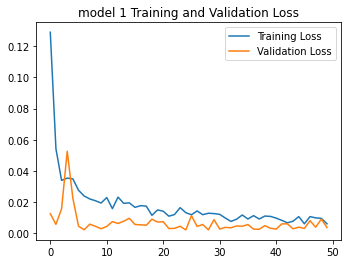

In [ ]:
#acc = train_model.history['accuracy']
#val_acc = train_model.history['val_accuracy']
import matplotlib.pyplot as plt
loss = train_model.history['loss']
val_loss = train_model.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('model 1 Training and Validation Loss')
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             16896     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 115,841
Trainable params: 115,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import math
from sklearn.metrics import mean_squared_error

# make predictions
predict_train = model.predict(x_train)
predict_test = model.predict(x_test)
# invert predictions
predict_train = scaler_views.inverse_transform(predict_train)
y_train = scaler_views.inverse_transform(y_train)
predict_test = scaler_views.inverse_transform(predict_test)
y_test= scaler_views.inverse_transform(y_test)
nsamples, nx, ny = x_test.shape
d2_x_test = x_test.reshape((nsamples,nx*ny))
x_test_rev = scaler_views.inverse_transform(d2_x_test)
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(predict_train, y_train))
print('Train Score: %.2f RMSE' % (trainScore))
valScore = math.sqrt(mean_squared_error(predict_test, y_test))
print('Val Score: %.2f RMSE' % (valScore))
predict = scaler_views.inverse_transform(model.predict(x_test))
print ("the demo predict is %s" %(predict.astype('int')[10:20]))
print ("the demo train is %s" %(x_test_rev[10:20]))
print ("the demo true is %s" %(y_test.astype('int')[10:20]))
#print(y_test[0:50])

86/86 [==============================] - 0s 5ms/step
Train Score: 425729.33 RMSE
Val Score: 379593.89 RMSE
86/86 [==============================] - 0s 5ms/step
the demo predict is [[ 1102816]
 [ 1840520]
 [  445713]
 [  968614]
 [  542769]
 [ 2444943]
 [ 5857182]
 [ 5573454]
 [ 2084747]
 [13144133]]
the demo train is [[  519623.   766167.   835582.   902875.   937627.]
 [ 1382225.  1404916.  1564969.  1621845.  1681713.]
 [  172040.   208791.   222006.   228688.   234884.]
 [  402647.   560134.   645619.   732011.   784235.]
 [  206703.   292697.   323838.   343023.   345813.]
 [ 1336020.  1721129.  1959172.  2119100.  2270690.]
 [ 4755586.  5196441.  5443108.  5618107.  5702575.]
 [ 4230805.  4593334.  4928864.  5165405.  5346463.]
 [  939081.  1500943.  1771438.  1897154.  1963604.]
 [ 6370515.  7815386.  9638948. 10729015. 12139092.]]
the demo true is [[  951120]
 [ 1726825]
 [  237630]
 [  825176]
 [  347088]
 [ 2370577]
 [ 5753953]
 [ 5484760]
 [ 2009606]
 [13034795]]


In [ ]:
@anvil.server.callable
def view_performance(): 
    return trainScore,valScore,predict.astype('int')[0:10],x_test_rev.astype('int')[0:10], y_test.astype('int')[0:10]
    print('Train Score: %.2f RMSE' % (trainScore))
    print('Val Score: %.2f RMSE' % (valScore))
    print ("the demo predict is %s" %(predict.astype('int')[0:10]))
    print ("the demo train is %s" %(x_test_rev.astype('int')[0:10]))
    print ("the demo true is %s" %(y_test.astype('int')[0:10]))

In [ ]:
scaler_likes, US_likes = standardize(US2.likes.values.reshape(-1,1))
scaler_dislikes, US_dislikes = standardize(US2.dislikes.values.reshape(-1,1))
scaler_comment_count, US_comment_count = standardize(US2.comment_count.values.reshape(-1,1))

In [ ]:
mean_likes = scaler_likes.mean_
mean_dislikes = scaler_dislikes.mean_
mean_comment_count = scaler_comment_count.mean_
mean_likes = mean_likes[0]
mean_dislikes = mean_dislikes[0]
mean_comment_count = mean_comment_count[0]
var_likes = scaler_likes.var_
var_dislikes = scaler_dislikes.var_
var_comment_count = scaler_comment_count.var_
sd_likes = math.sqrt(var_likes)
sd_dislikes = math.sqrt(var_dislikes)
sd_comment_count = math.sqrt(var_comment_count)


In [ ]:
US4 = pd.DataFrame()
US4["trending_date1"] = US2["trending_date1"]
US4["video_id"] = US2["video_id"]
US4["views"] = US_views
US4["likes"] = US_likes
US4["dislikes"] = US_dislikes
US4["comment_count"] = US_comment_count

In [ ]:
US4

,trending_date1,video_id,views,likes,dislikes,comment_count
0,2020-08-12,3C66w5Z0ixs,-0.220228,-0.052697,0.256145,0.174429
1,2020-08-12,49Z6Mv4_WCA,-0.283607,-0.185746,-0.056860,-0.085150
2,2020-08-12,nt3VVyv5pxQ,-0.322016,-0.267606,-0.170544,-0.125564
4,2020-08-12,gPdUslndvVI,-0.356707,-0.280254,-0.187155,-0.116250
22,2020-08-13,3C66w5Z0ixs,-0.054414,-0.001831,0.542198,0.230099
...,...,...,...,...,...,...
170985,2022-04-26,F-kvFACZ5yE,0.273859,-0.217826,-0.202589,0.028818
170986,2022-04-27,F-kvFACZ5yE,0.274911,-0.217598,-0.202589,0.028910
170987,2022-04-29,F-kvFACZ5yE,0.276500,-0.217184,-0.202589,0.028947
170988,2022-04-30,F-kvFACZ5yE,0.277168,-0.217022,-0.202589,0.028883


In [ ]:
x_four=[]
y_four=[]
for v in videos:
    row=[]
    temp_df = US3[US3["video_id"]==v].sort_values(by="trending_date1")
    
    seq = temp_df.views[0:5].index #first 5 views as input
    #print seq
    #print(seq)    
    for s in seq:
        #print (US3.iloc[s].values[2:])
        row.append(US4.iloc[s].values[2:])
    #print(row)
        
    x_four.append(row)
    nextstep = temp_df.views[5:6].values # the last views as output
    y_four.append(nextstep)

In [ ]:
x_four = np.reshape(x_four,(len(x_four),20,1)) # new
#print (x.shape)
y_four = np.reshape(y_four,(-1,1))
#print (y.shape)
x_four = x_four.astype('float64')
y_four = y_four.astype('float64')
#print(x_four)

In [ ]:
x_train_new,x_testall_new,y_train_new,y_testall_new = train_test_split(x_four,y_four,test_size=0.4,random_state=42)
x_val_new,x_test_new,y_val_new,y_test_new = train_test_split(x_testall_new,y_testall_new,test_size=0.5,random_state=42)

In [ ]:
model_new = Sequential()
model_new.add(LSTM(64, return_sequences=True,input_shape=(20, 1),activation='tanh'))
model_new.add(Dropout(0.2))
model_new.add(LSTM(128,return_sequences=False,activation='tanh'))
model_new.add(Dense(1, activation='linear'))#1 is output
#optimizer = RMSprop(lr=0.005)
optimizer = RMSprop(learning_rate=0.005)
model_new.compile(loss='mean_squared_error', optimizer=optimizer)
#from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='view_count5+like+dislike+comment_count_predict_view_count_future.hdf5', 
                               verbose=1, save_best_only=True)

train_model_new = model_new.fit(x_train_new, y_train_new, 
          validation_data=(x_val_new, y_val_new),
          epochs=50, batch_size=64, callbacks=[checkpointer], verbose=1)
model_new.load_weights('view_count5+like+dislike+comment_count_predict_view_count_future.hdf5')

Epoch 1/50
127/128 [============================>.] - ETA: 0s - loss: 0.3352
Epoch 1: val_loss improved from inf to 0.12158, saving model to view_count5+like+dislike+comment_count_predict_view_count_future.hdf5
128/128 [==============================] - 12s 61ms/step - loss: 0.3357 - val_loss: 0.1216
Epoch 2/50
128/128 [==============================] - ETA: 0s - loss: 0.1467
Epoch 2: val_loss improved from 0.12158 to 0.08073, saving model to view_count5+like+dislike+comment_count_predict_view_count_future.hdf5
128/128 [==============================] - 7s 55ms/step - loss: 0.1467 - val_loss: 0.0807
Epoch 3/50
127/128 [============================>.] - ETA: 0s - loss: 0.1004
Epoch 3: val_loss improved from 0.08073 to 0.02716, saving model to view_count5+like+dislike+comment_count_predict_view_count_future.hdf5
128/128 [==============================] - 7s 55ms/step - loss: 0.0999 - val_loss: 0.0272
Epoch 4/50
128/128 [==============================] - ETA: 0s - loss: 0.0704
Epoch 4: va

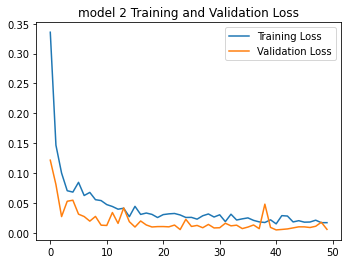

In [ ]:
loss_new = train_model_new.history['loss']
val_loss_new = train_model_new.history['val_loss']

epochs_range = range(len(loss_new))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_new, label='Training Loss')
plt.plot(epochs_range, val_loss_new, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('model 2 Training and Validation Loss')
plt.show()

In [ ]:
def transfer_x_test(x_test_new): 
    y_test_new = x_test_new[0:10]
    #print(y_test_new)
    y_test_view=[]
    y_test_like=[]
    y_test_dislike=[]
    y_test_comment=[]
    for j in range(0,10): 
        for i in range(0,20,4):
            y_test_view.append(y_test_new[j][i][0])
        #print(y_test_view)
        for i in range(1,20,4):
            y_test_like.append(y_test_new[j][i][0])
        for i in range(2,20,4):
            y_test_dislike.append(y_test_new[j][i][0])
        for i in range(3,20,4):
            y_test_comment.append(y_test_new[j][i][0])
    return y_test_view, y_test_like,  y_test_dislike,y_test_comment

In [ ]:
# make predictions
predict_train_new  = model_new.predict(x_train_new)
predict_test_new  = model_new.predict(x_test_new)
# invert predictions
predict_train_new  = scaler_views.inverse_transform(predict_train_new)
y_train_new  = scaler_views.inverse_transform(y_train_new)
predict_test_new  = scaler_views.inverse_transform(predict_test_new)
y_test_new = scaler_views.inverse_transform(y_test_new)
# calculate root mean squared error
#x_test_new_view_rev = scaler_views.inverse_transform(x_test_new)[view,like,dislike,comment_count]
#
view_new, like_new, dislike_new, comment_count_new = transfer_x_test(x_test_new)
#print(dislike_new)
# reverse 
view_new = np.reshape(view_new,(int(len(view_new)/5),5))
view_new = scaler_views.inverse_transform(view_new)
#print(view_new)
like_new = np.reshape(like_new,(int(len(like_new)/5),5))
like_new = scaler_likes.inverse_transform(like_new)

dislike_new  = np.reshape(dislike_new ,(int(len(dislike_new )/5),5))
dislike_new = scaler_dislikes.inverse_transform(dislike_new)

comment_count_new = np.reshape(comment_count_new,(int(len(comment_count_new)/5),5))
comment_count_new = scaler_comment_count.inverse_transform(comment_count_new)
#print(dislike_new)
#print(view_new)

trainScore_new = math.sqrt(mean_squared_error(predict_train_new , y_train_new))
print('Train Score: %.2f RMSE' % (trainScore_new))
valScore_new = math.sqrt(mean_squared_error(predict_test_new , y_test_new))
print('Val Score: %.2f RMSE' % (valScore_new))
predict_new = scaler_views.inverse_transform(model_new .predict(x_test_new))
print ("the demo predict is %s" %(predict_new.astype('int')[0:5]))
#print ("the demo train is %s" %(x_test_new_rev[0:10]))
#print ("the demo true is %s" %(y_test_new .astype('int')[0:5]))
print ("the training view %s"%(view_new .astype('int')[0:5]))
#print ("the training like %s"%(like_new .astype('int')[0:5]))
#print ("the training dislike %s"%(dislike_new .astype('int')[0:5]))
#print ("the training comment %s"%(comment_count_new .astype('int')[0:5]))

86/86 [==============================] - 1s 14ms/step
Train Score: 719839.40 RMSE
Val Score: 440063.19 RMSE
86/86 [==============================] - 1s 15ms/step
the demo predict is [[ 696028]
 [ 875893]
 [1121110]
 [2366835]
 [ 619444]]
the training view [[ 337992  607512  675045  714087  741687]
 [ 276047  508829  660641  780960  887037]
 [ 579895  810473  919809 1021239 1147364]
 [1435604 1821742 2075277 2231244 2357817]
 [ 307630  515174  617406  662177  696249]]


In [ ]:
@anvil.server.callable
def plus_view_performance(): 
    return trainScore_new,valScore_new,predict_new.astype('int')[0:5], y_test_new.astype('int')[0:5],view_new .astype('int')[0:5],like_new.astype('int')[0:5], dislike_new.astype('int')[0:5], comment_count_new .astype('int')[0:5] 
    

In [ ]:
model_new.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 20, 64)            16896     
                                                                 
 dropout_1 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               98816     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 115,841
Trainable params: 115,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
@anvil.server.callable
def predict_fifth_day_by_view_count(input_day_1,input_day_2,input_day_3,input_day_4,input_day_5): 
    #print(input_day_1)
    #print(type(input_day_1))
    data = []
    #need to standardlized first
    #ddd = (input_day_1-mean_view)/sqr_view #ddd is an array???????
    data.append([(input_day_1-mean_view)/sqr_view])
    data.append([(input_day_2-mean_view)/sqr_view])
    data.append([(input_day_3-mean_view)/sqr_view])
    data.append([(input_day_4-mean_view)/sqr_view])
    data.append([(input_day_5-mean_view)/sqr_view])
    #data.append([d6])
    print("this is sd data.")
    print(data)
    predict_data = model.predict([data])
    print("this is sd predict data")
    print(predict_data)
    predict_data = (predict_data*sqr_view)+mean_view
    return predict_data.astype('int')

In [ ]:
#(input_day_1-mean_view)/sqr_view     ++ mean_likes, mean_dislikes, mean_comment_count, sd_likes,sd_dislikes,sd_comment_count
# view, like,dislike,coumment_count
@anvil.server.callable
def predict_fifth_day_by_view_count_plus_others(a1,a2,a3,a4,a5,b1,b2,b3,b4,b5,c1,c2,c3,c4,c5,d1,d2,d3,d4,d5): 
    data1 = [(a1-mean_view)/sqr_view],[(b1-mean_likes)/sd_likes],[(c1-mean_dislikes)/sd_dislikes],[(d1-mean_comment_count)/sd_comment_count]
    data2 = [(a2-mean_view)/sqr_view],[(b2-mean_likes)/sd_likes],[(c2-mean_dislikes)/sd_dislikes],[(d2-mean_comment_count)/sd_comment_count]
    data3 = [(a3-mean_view)/sqr_view],[(b3-mean_likes)/sd_likes],[(c3-mean_dislikes)/sd_dislikes],[(d3-mean_comment_count)/sd_comment_count]
    data4 = [(a4-mean_view)/sqr_view],[(b4-mean_likes)/sd_likes],[(c4-mean_dislikes)/sd_dislikes],[(d4-mean_comment_count)/sd_comment_count]
    data5 = [(a5-mean_view)/sqr_view],[(b5-mean_likes)/sd_likes],[(c5-mean_dislikes)/sd_dislikes],[(d5-mean_comment_count)/sd_comment_count]
    input_data = []
    for i in range(0,4):
        input_data.append(data1[i])
    for i in range(0,4):
        input_data.append(data2[i])
    for i in range(0,4):
        input_data.append(data3[i])
    for i in range(0,4):
        input_data.append(data4[i])
    for i in range(0,4):
        input_data.append(data5[i])
    print(input_data)
    predict_data = model_new.predict([input_data])
    print(predict_data)
    predict_data = (predict_data*sqr_view)+mean_view
    return predict_data